<a href="https://colab.research.google.com/github/biagzi/ictp-origins-phylogenetic-tutorial/blob/main/PhylogeneticTutorial_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing dependences


In [16]:
install.packages("phytools")
install.packages("geiger")
install.packages("caper")

library(geiger)
library(phytools)
library("ggplot2")
library("caper")



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# The main models behind phylogenetic corrections - continuous traits


Continuous traits, such as body size, can vary significantly depending on factors like food availability throughout an organism’s life. However, genetically inherited constraints limit the extent of this variation within each species. No matter how much food you give to a rat, it will never grow to the size of an elephant. For this reason, we can assume that each species has an `average body size` given by the different values of adult body size within its population.

Body size is a complex phenotypic trait shaped by the interaction of multiple genes in specific contexts during development. These genetic factors do not act in isolation — they interact with each other and with environmental conditions, ultimately determining the "typical body size" of a species.

Now, let’s consider a hypothetical species, X, with an average body size of
𝑆x. Let's also assume that the body size of this species does not affect its fitness. This is not very realistic, but we can add selection later.
Over thousands of generations of X, random mutations will accumulate, and the average body size of species X might shift slightly to 𝑆x + Δ𝑥. After even more time, and assuming these changes do not significantly affect fitness, the accumulation of more random mutations can then push the typical body size to another direction, like 𝑆x - 3Δ𝑥, or to any other value.

This gradual, undirected change in trait values due to the accumulation of neutral mutations can be modeled as a Brownian motion.

Brownian motion describes a specific type of continuous and random movement of a particle over time due to small, cumulative influences (such as the shock of small particles). It was named after the Scottish botanist Robert Brown, who in 1827 described the movement of pollen immersed in water.

![Check this link to see a gif of Brownian motion](https://upload.wikimedia.org/wikipedia/commons/c/c2/Brownian_motion_large.gif)


The core idea is that the movement of the object (or the variation we observe in a trait) is the result of the sum of a large number of very small random forces (or accumulation of random genetic mutation).

### Brownian motion

Phylogenetic models of Brownian motion models are fully characterized by two parameters.

*  The first is a initial value z(0) for the trait. In our case: the initial mean size of the population (Sx) before any evolutionary change occurs.
*  The second parameter is the evolutionary rate, σ² , which dictates how fast traits will randomly change through time.

Under Brownian motion, changes in trait values over any interval of time are drawn from a normal distribution with mean 0 and with variance tσ².
Let's visualize some examples:

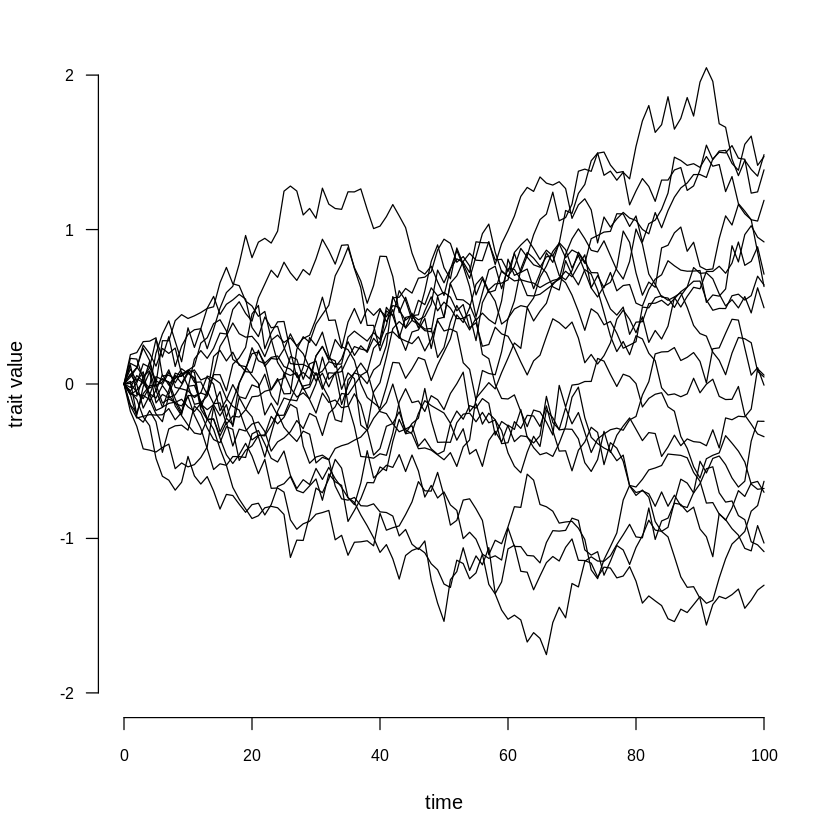

In [17]:
#@title Simulating Brownian motion
#@markdown In the plot, each black line is a different simulation. The y axis has the trait value (body size, for example), and the x axis is time

# set number of simulations
t<-0:100
sig2<-0.01
nsim<-20
# create matrix of random normal deviates
X<-matrix(rnorm(n=nsim*(length(t)-1),sd=sqrt(sig2)),
nsim,length(t)-1)
# calculate the cumulative sum of these deviates
# this is now a simulation of Brownian motion
X<-cbind(rep(0,nsim),t(apply(X,1,cumsum)))
# plot the first one
par(mar=c(5.1,4.1,2.1,2.1))
plot(t,X[1,],ylim=c(-2,2),type="l",bty="n",
xlab="time",ylab="trait value",las=1,
cex.axis=0.8)
# plot the rest
invisible(apply(X[2:nsim,],1,function(x,t) lines(t,x),t=t))

Next, we will simulate Brownian motion along a phylogenetic tree.

For a given trait (e.g., body size), whenever a speciation event occurs, the trait begins to evolve independently in each descendant lineage, by independent Brownian motion processes.

We can observe that the amount of variation accumulated between species tends to increase with time as the distance from their last common ancestor increases.

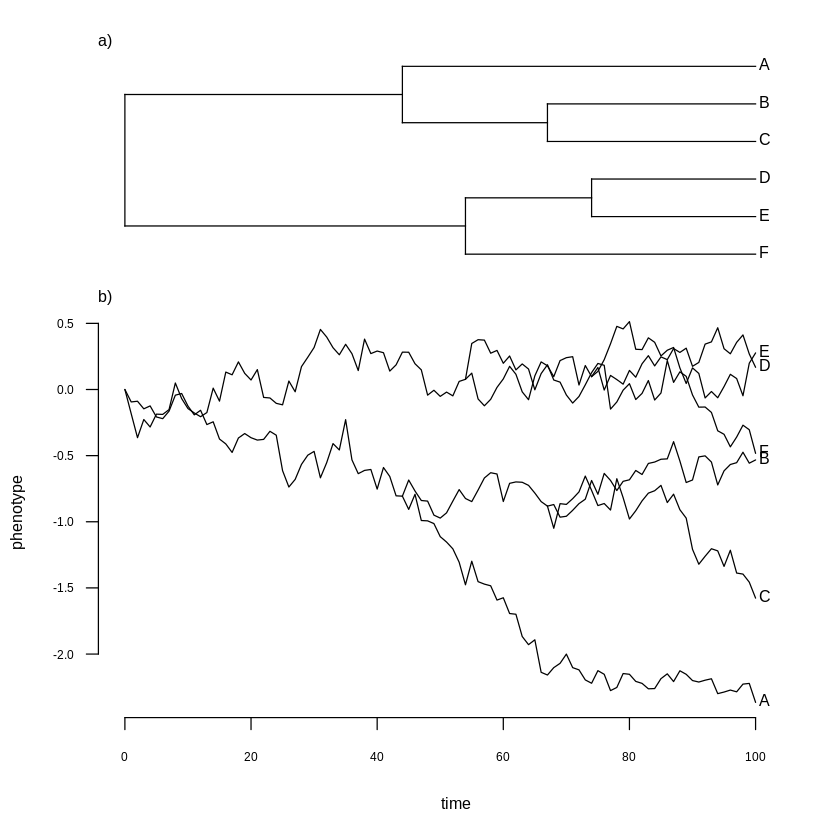

In [ ]:
#@title Simulating Brownian motion in a phylogenetic tree
#@markdown The y axis is still the trait value (body size, for example)


set.seed(123)
## simulate a tree and Brownian evolution on that tree using simBMphylo
object<-simBMphylo(n=6,t=100,sig2=0.01,
fsize=0.8,cex.axis=0.6,cex.lab=0.8,
las=1)

#### Relevant properties of Brownian motion for phylogenetic analysis

Many alternative models, with greater biological realism and complexity, could be used to describe this same phenomena. However, Brownian motion is the dominant approach for continuos traits in comparative phylogenetics because it has some very convenient statistical properties that allow relatively simple analyses and calculations on trees:

1.   stochastic and directionless
2.   variation accumulates through time: which in phylogenetic trees implies that more close related species will tend to have more similar trait values.


#### Brownian motions does not imply genetic drift!

In evolution, **genetic drift** describes:

> random fluctuations in the numbers of gene variants in a population. Genetic drift takes place when the occurrence of variant forms of a gene, called alleles, increases and decreases by chance over time. These variations in the presence of alleles are measured as changes in allele frequencies. (Nature Education)

In the example of species X we were assuming that body size does not affect fitness, in other words, a process without selection.
However, if a trait is evolving as expected under a Brownian motion, it does not necessary imply that the trait is not under selection.
Selection can occur in specific ways that maintain the properties of Brownian motion.
Some examples are:
- if the strength and direction of selection is weak and varies randomly from one generation to the next.
- if there is a strong selection for a particular optimal value, but this particular optimal value changes randomly as a Brownian motion.

Thus, Brownian motion allows us to model continuous changes of trait values in a genetic tree, both in the case of genetic drift and specific selection patterns. It is very useful model, and we can use it, for example, as a null model to test hypothesis about selection forces.


For a detailed derivation of a Brownian process model in population genetics, see Chapter 3 of Phylogenetic Comparative Methods, Luke J. Harmon, 2019 (online version available)



### Phylogenetic Signal

As already mentioned, Brownian motion models can be used as null models to test against specific hypothesis.

This brings us to **phylogenetic signal**, an essential concept in phylogenetic analysis.


> Phylogenetic signal indicates how much a species' trait vary from what we would expect if it was governed by a Brownian motion process (such as genetic drift or a randomly varying selection).


In the literature, there are two main forms of measuring phylogenetic signal:

*   Pagel's λ (Pagel’s, 1999a)
*   Blomberg's K (Blomberg et al.’s, 2003)

#### Pagel's λ

In 1999, Mark Pagel introduced three different parameters to model transformations in a tree (Pagel 1999a,b).

<div>
<img src="https://raw.githubusercontent.com/biagzi/ictp-origins-phylogenetic-tutorial/refs/heads/main/images/pagel_transformations_from_Harmon_2019.png" width="600"/>
</div>
[Figure 1 - Pagel's tranformations. Image from Harmon 2019]

One of them, the λ transformation, is a scalling parameter λ ϵ [0,1] in the off-diagonal elements of the matrix of phylogenetic
variance-covariance matrix **C** (a matrix with the expected correlations among each pair of species).

If there are n species in a phylogenetic tree, **C** will have a size of n x n and be symetrical. The diagonal has a measure of the distance of each species from the root of the tree. The off-diagonal elements represent the shared branch lenght by each pair of species.


<div>
<img src="https://raw.githubusercontent.com/biagzi/ictp-origins-phylogenetic-tutorial/refs/heads/main/images/matrix_C_Harmon_2019.png" width="500"/>
</div>
[Figure 2 - The phylogenetic variance-covariance matrix C. Image from Harmon 2019]

For more details, see Chapter 3 and 6 of Phylogenetic Comparative Methods, Luke J. Harmon, 2019.

The main idea is that with this matrix and a value of σ², we can completely describe the expected statistical distribution of traits on the tips of a phylogenetic tree under a Brownian motion model.

We can fit this model to trait data and estimate the σ² and the z(0) that maximizes the likelihood for the trait distribution in a specific phylogenetic tree.

If we now introduce a new parameter λ as a scalling coefficient in the off-diagonal elements and fit the trait data to this new model, values of λ = 1 correspond with the original matrix. Values of λ < 1 correspond to **less phylogenetic signal** than expected under a Brownian motion model.

<div>
<img src="https://raw.githubusercontent.com/biagzi/ictp-origins-phylogenetic-tutorial/refs/heads/main/images/matric_C_with_lambda_Harmon_2019.png" width="300"/>
</div>
[Figure 3 - Lambda scaling. Image from Harmon 2019]


The interpretation of lambda becomes clear by examining the tree in Figure 1 after applying the λ = 0.3 transformation. A weak phylogenetic signal in a trait W suggests that species appear to have evolved independently for a longer time for this trait, likely due to stronger selection pressures acting on it.


#### Blomberg's K




It’s important to note that we should not expect a direct one-to-one correspondence between K and λ. These two metrics assess different aspects of phylogenetic signal, so we should anticipate differences between them (see Boettiger et al. 2012 for further discussion on λ estimation).

## Modeling continuous character evolution on a phylogeny


### Estimating phylogenetic signal in a real dataset

The orbit size of primates varies considerably, primarily due to differences in head size.


<div>
<img src="https://raw.githubusercontent.com/biagzi/ictp-origins-phylogenetic-tutorial/refs/heads/main/images/primates_orbits.png" width="900"/>
</div>

An additional hypothesis for variation in orbit size suggests that species with nocturnal activity patterns should have relatively larger orbits to enhance light capture in low-light environments, thereby improving nocturnal vision.

Past studies found a strong association between nocturnal activity patterns and orbit size across primates (Walker 1967, Cartmill 1970, Kay & Cartmill 1977, Martin 1990, Kay & Kirk 2000).

Let's first visualize the distribution of orbit size given different skulls size for primates.


In [166]:
#@title Click here to download the primates' orbit dataset


data_url <-"https://raw.githubusercontent.com/biagzi/ictp-origins-phylogenetic-tutorial/refs/heads/main/data/kaykirk2004.csv"
data <- read.csv(data_url)
head(data)

,Genus_species,Group,Skull_length,Optic_foramen_area,Orbit_area,Activity_pattern,Activity_pattern_code
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,Allenopithecus_nigroviridis,Anthropoid,98.5,7.0,298.7,Diurnal,0
2,Alouatta_palliata,Anthropoid,109.8,5.3,382.3,Diurnal,0
3,Alouatta_seniculus,Anthropoid,108.0,8.0,359.4,Diurnal,0
4,Aotus_trivirgatus,Anthropoid,60.5,3.1,297.4,Nocturnal,2
5,Arctocebus_aureus,Prosimian,49.5,1.2,134.8,Nocturnal,2
6,Arctocebus_calabarensis,Prosimian,53.8,1.6,156.6,Nocturnal,2


Description of the variables:

*   Genus_species:  Genus and species name

*   Group: Prosimian (lemurs, tarsiers) or Anthropoid (monkeys and apes)

*   Skull_length: Prosthion-inion linear distance in mm

*   Optic_foramen_area: Optic forament area in square mm

*   Orbit_area: Orbit area estimated from orbit diameter in square mm

*   Activity_pattern: Diurnal, cathemeral, or nocturnal
(Cathemeral = irregular intervals during the day or night)

*   Activity_pattern_code - 0 = Diurnal, 1 = Cathemeral, and 2 = Nocturnal






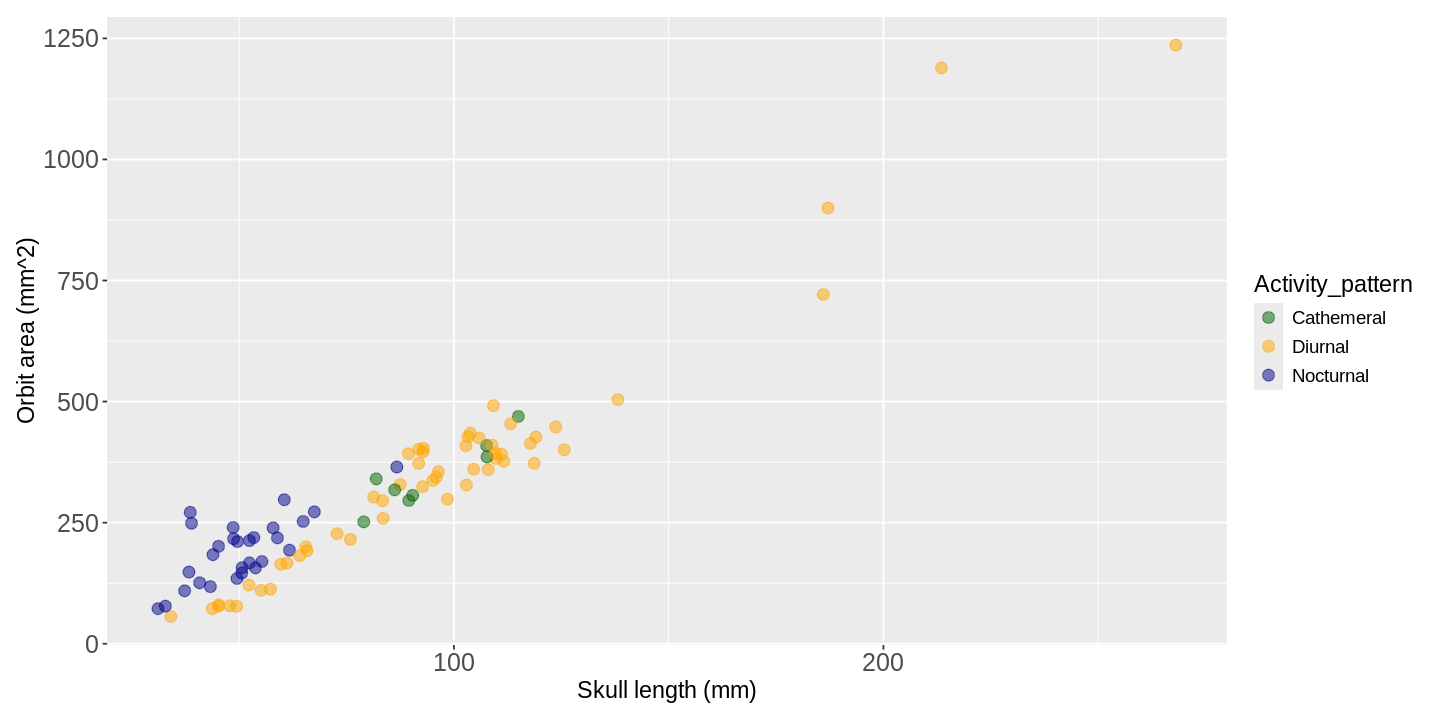

In [39]:
# scatterplot of orbit area X skull length

options(repr.plot.width = 12, repr.plot.height = 6)  # adjust these numbers to your liking

ggplot(data, aes(Skull_length, Orbit_area, color=Activity_pattern)) + geom_point(alpha=0.5, size=3) +
  scale_color_manual(values=c("darkgreen","orange","darkblue")) +
  xlab("Skull length (mm)") + ylab("Orbit area (mm^2)") +
  theme(plot.margin = margin(10, 10, 10, 10), text = element_text(size=14), axis.text=element_text(size=15))

Visually, it appears that nocturnal species tend to have a relatively larger orbit area compared to diurnal species with a similar skull length.
However, these past studies did not account for the species' phylogenetic signal.
Let's calculate the regression lines for each activity pattern and check if they are significantly different.

In [46]:
# Fit a linear model to the data for each activity pattern
lm_model <- lm(Orbit_area ~ Skull_length  + Activity_pattern_code, data = data)
# Display the model summary
summary(lm_model)
# Perform an F-test to compare slopes
anova(lm_model)


Call:
lm(formula = Orbit_area ~ Skull_length + Activity_pattern_code, 
    data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-99.658 -33.601  -4.527  27.488 228.884 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -158.1029    17.4092  -9.082 3.06e-14 ***
Skull_length             5.2376     0.1613  32.462  < 2e-16 ***
Activity_pattern_code   41.4516     7.0501   5.880 7.44e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 51.8 on 87 degrees of freedom
Multiple R-squared:  0.9337,	Adjusted R-squared:  0.9322 
F-statistic: 612.7 on 2 and 87 DF,  p-value: < 2.2e-16


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Skull_length,1,3195307.67,3195307.667,1190.83219,1.525332e-52
Activity_pattern_code,1,92758.95,92758.947,34.56955,7.441771e-08
Residuals,87,233443.28,2683.256,NA,NA


`geom_smooth()` using formula = 'y ~ x'


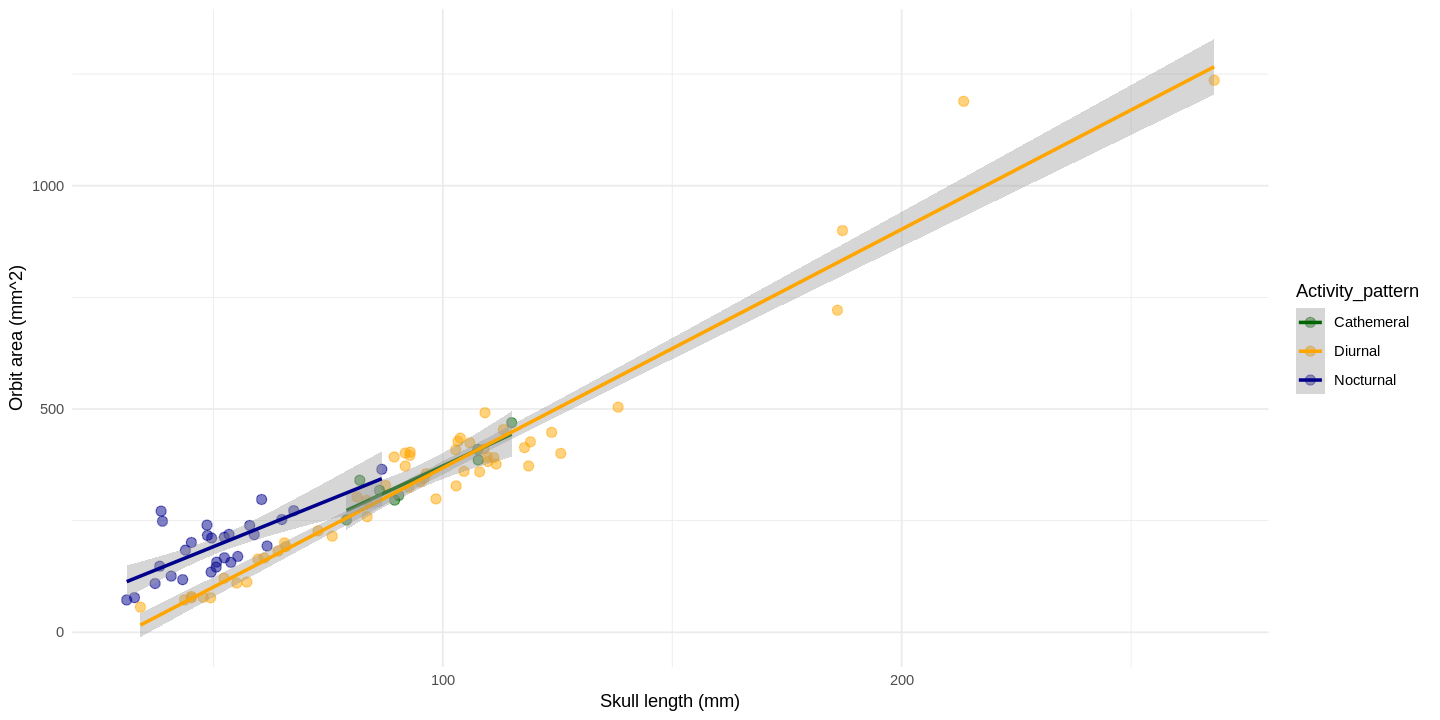

In [43]:
# Fit the plot with linear regression lines
ggplot(data, aes(Skull_length, Orbit_area, color = Activity_pattern)) +
  geom_point(alpha = 0.5, size = 2.5) +
  scale_color_manual(values = c("darkgreen", "orange", "darkblue")) +
  xlab("Skull length (mm)") +
  ylab("Orbit area (mm^2)") +
  geom_smooth(method = "lm", aes(group = Activity_pattern), se = TRUE) + # Add regression lines
  theme_minimal()

By using an Ordinary Least Squares regression we would conclude that the orbit area is signficantly associated with the activity pattern (p<0.001).

However, as we previously discussed, without accounting for species phylogeny we can't rule out that traits are associated solely due their shared evolutionary history. Closely related species are expected to exhibit more similar traits — as we predicted under a Brownian motion model— unless strong selection pressures have shaped those traits independently.

As we saw, phylogenetic signal can be used to infer the degree to which phylogeny explains the variation in a specific trait.

We will use Pagel's λ and Blomberg's K to evaluate the phylogenetic signal of primates orbit and skull size.

This analysis was inspired by a post in the [blog of Randi H Griffin](https://www.randigriffin.com/2017/11/17/primate-orbit-size.html).

In [162]:
#@title Click here to download the primates phylogenetic tree

# tree_url <- "https://raw.githubusercontent.com/biagzi/ictp-origins-phylogenetic-tutorial/refs/heads/main/data/primate_tree.nex"
# trees <- read.nexus(tree_url)
# #choose one of the trees
# primate_tree <- trees[[1]]
# primate_tree

tree_url <- "http://raw.githubusercontent.com/biagzi/ictp-origins-phylogenetic-tutorial/refs/heads/main/data/primateEyes.phy"
primate_tree <- read.tree(tree_url)
primate_tree


Phylogenetic tree with 90 tips and 89 internal nodes.

Tip labels:
  Allenopithecus_nigroviridis, Cercopithecus_mitis, Cercopithecus_cephus, Cercopithecus_petaurista, Erythrocebus_patas, Chlorocebus_aethiops, ...

Rooted; includes branch length(s).

The number of tips gives the number of species in the tree. Let's plot our tree to see if it is working properly:

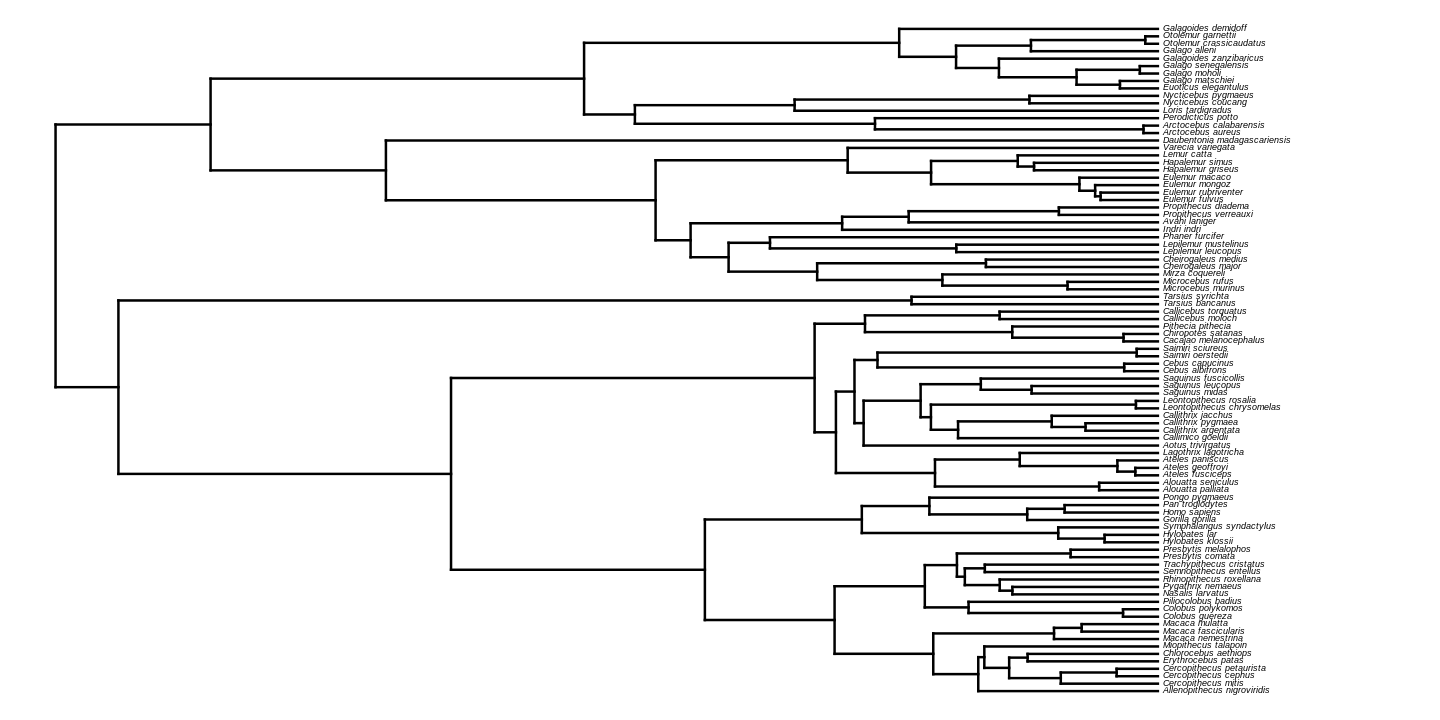

In [163]:
## graph phylogeny using plotTree
plotTree(primate_tree,ftype="i",fsize=0.45,
lwd=2,mar=c(0.1,0.1,0.1,0.1),pin=c(6, 12))

In [170]:
#It is import to check if the species labels in our phylogenetic tree are the same of our dataset. To do it, we use a funtion of the library "geiger":
rownames(data) <- data$Genus_species

chk <- name.check(phy = primate_tree, data = data)
print(chk)

[1] "OK"


In [172]:
# In our case, the tree and dataset match. If they didn't we would need to prune the tree to keep only the species present in the dataset, and vice versa:
#primate_tree<-drop.tip(primate_tree,chk$tree_not_data)
#data<-data[primate_tree$tip.label,]

#check after pruning
#chk2 <- name.check(phy = primate_tree, data = data)
#print(chk2)

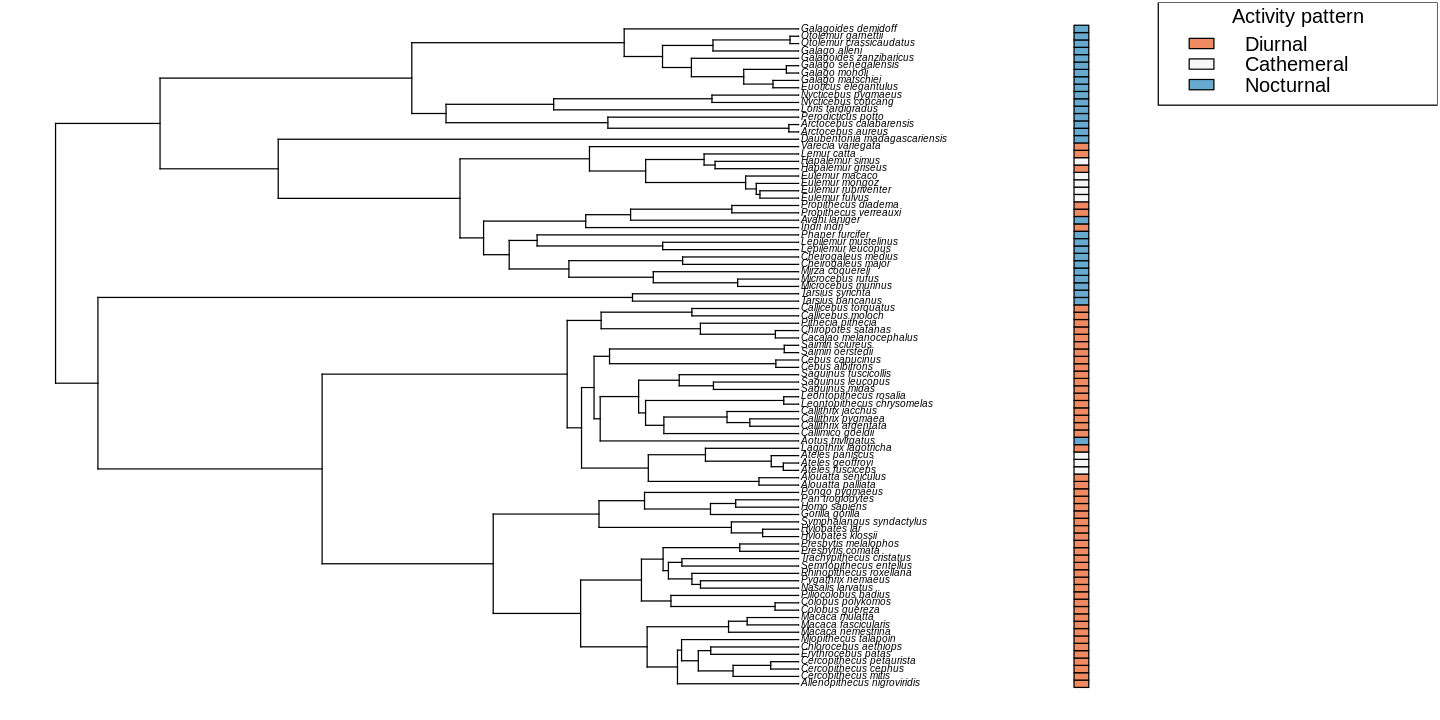

In [173]:
## plot the tree after pruning with the activity pattern distribution
subset_df <- data[c("Activity_pattern")]
subset_df$Activity_pattern <- factor(subset_df$Activity_pattern,levels = c("Diurnal", "Cathemeral", "Nocturnal"))
rownames(subset_df) <- data$Genus_species

object<-plotTree.datamatrix(primate_tree,subset_df,
fsize=0.5,yexp=1,header=FALSE,xexp=1.45,palettes=c("RdBu"))

leg<-legend(x = "topright",
       legend = names(object$colors$Activity_pattern),
       fill = object$colors$Activity_pattern,
       title="Activity pattern")


What do you think of the distribution of activity pattern styles in the tree?

In [174]:
#@title Code to calculate the phylogenetic signal for skull lenght
skull_lenght<-data[,"Skull_length"]
names(skull_lenght)<-rownames(data)

#With Pagel's lambda
Lambda_skull <- phylosig(primate_tree,skull_lenght,method="lambda")
Lambda_skull

#With Blomberg et al.’s K statistic
K_skull <- phylosig(primate_tree, skull_lenght)
K_skull


Phylogenetic signal lambda : 1.0101 
logL(lambda) : -392.308 



Phylogenetic signal K : 1.13922 


How to interpret this?

To interpret this value, it is useful to test whether the phylogenetic signal
we calculted significantly differs from the signal expected by random chance in our specific tree and dataset. Thus, our null hypothesis will be that the trait is random with respect to the phylogeny.

To do this, we can randomize the data across the tips of the tree multiple times, and for each time we can calculate the phylogenetic signal.
Thus, we should compare our calculated phylogenetic tree with the distribution of randomized phylogenetic signals.
Let's do it:


In [175]:
## test for significant phylogenetic signal using Blomberg’s K
K_test<-phylosig(primate_tree, skull_lenght, test=TRUE, nsim=10000)
K_test


Phylogenetic signal K : 1.13922 
P-value (based on 10000 randomizations) : 1e-04 


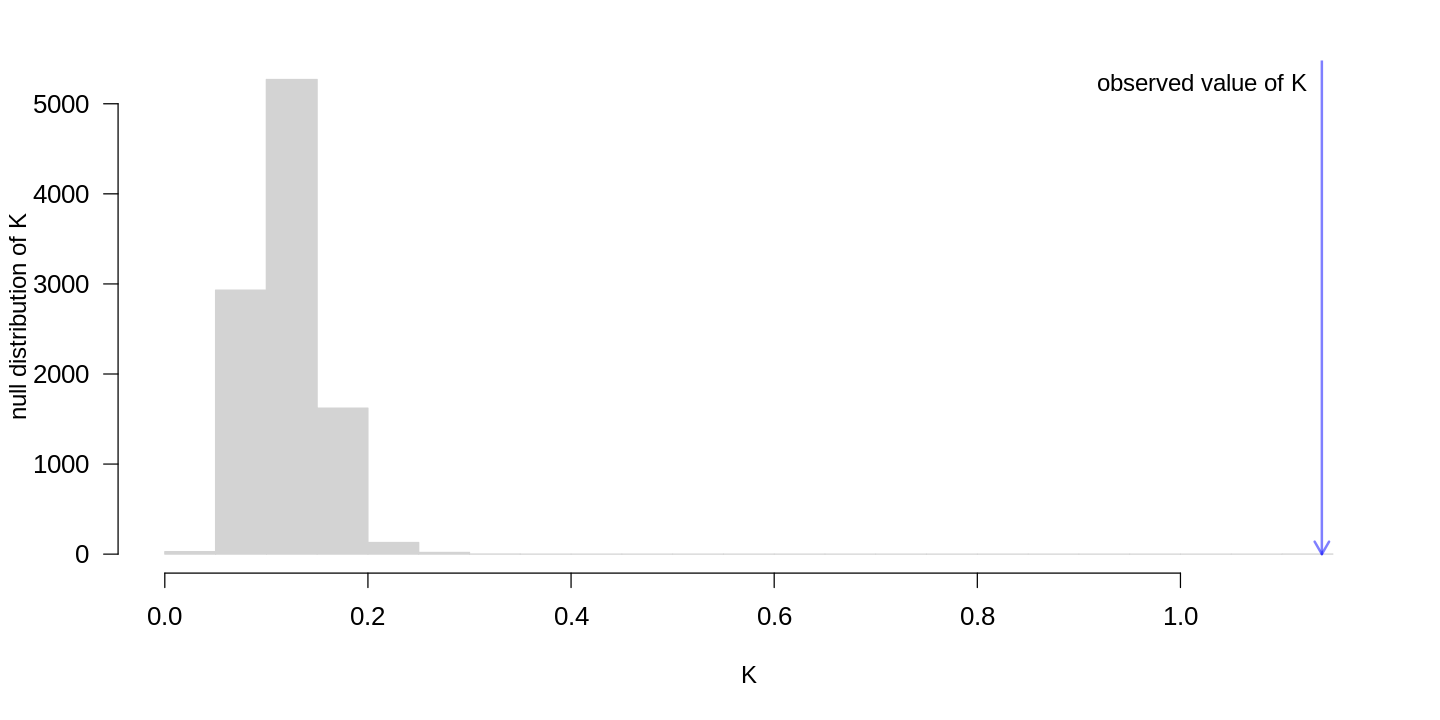

In [176]:
## plot null-distribution and observed value of K
## set plot margins and font size
par(cex=1.2,mar=c(5.1,4.1,2.1,2.1))
plot(K_test,las=1,cex.axis=0.9)

Our phylogenetic signal is highly significant, allowing us to reject the null hypothesis (p < 0.001).

Our observed phylogenetic signal value, K, is greater than the expected K if skull length were random with respect to phylogeny.

We can repeat the analysis for Pagel's lambda:

In [177]:
## test for significant phylogenetic signal, lambda,
## in each of our two traits
lambda_test <- phylosig(primate_tree,skull_lenght,method="lambda",test=TRUE)
lambda_test



Phylogenetic signal lambda : 1.0101 
logL(lambda) : -392.308 
LR(lambda=0) : 133.676 
P-value (based on LR test) : 6.43292e-31 


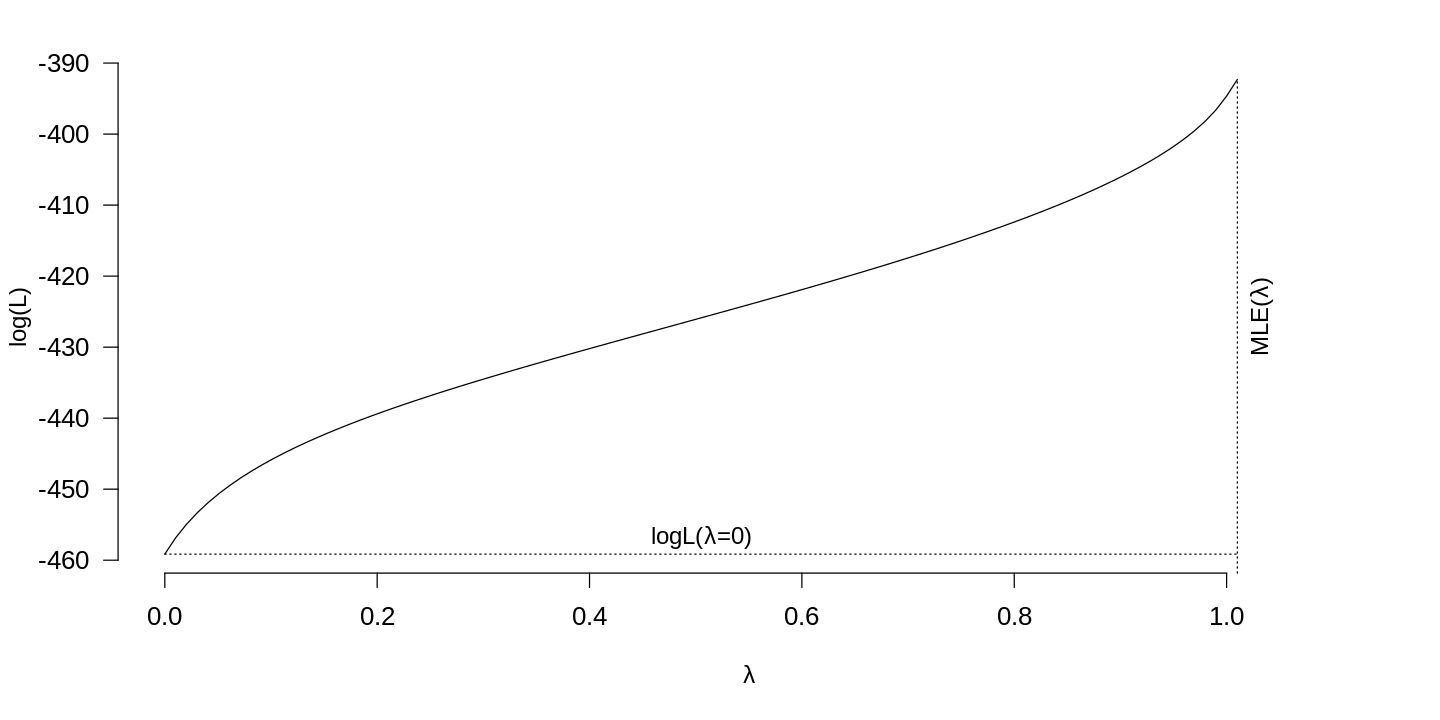

In [178]:
## plot the likelihood surfaces
## first set plotting parameters, including subdividing
par(cex=1.2,mar=c(5.1,4.1,2.1,2.1))
## plot the likelihood surfaces of lambda
plot(lambda_test,las=1,cex.axis=0.9,bty="n", xlim=c(0,1.1))

Thus, we can reject the null hypothesis (in which λ = 0), as the maximum likelihood estimation (MLE) occurs at λ around 1.
Lambda is usually not interpretable when it is higher then 1. So the only meaninful conclusion we can have is that the phylogenetic signal is high and relevant.

In [179]:
#@title What is the phylogenetic signal of orbit area?
#@markdown Based on the previous example, you should use the same functions and procediment to calculate the phylogenetic signal for orbit area

orbit_area <-data[,"Orbit_area"]
names(orbit_area)<-rownames(data)

#With Pagel's lambda
Lambda_orbit <- phylosig(primate_tree,orbit_area,method="lambda")
Lambda_orbit

#With Blomberg et al.’s K statistic
K_orbit <- phylosig(primate_tree, orbit_area)
K_orbit


Phylogenetic signal lambda : 1.00901 
logL(lambda) : -547.819 



Phylogenetic signal K : 0.861342 



Phylogenetic signal K : 0.861342 
P-value (based on 10000 randomizations) : 1e-04 


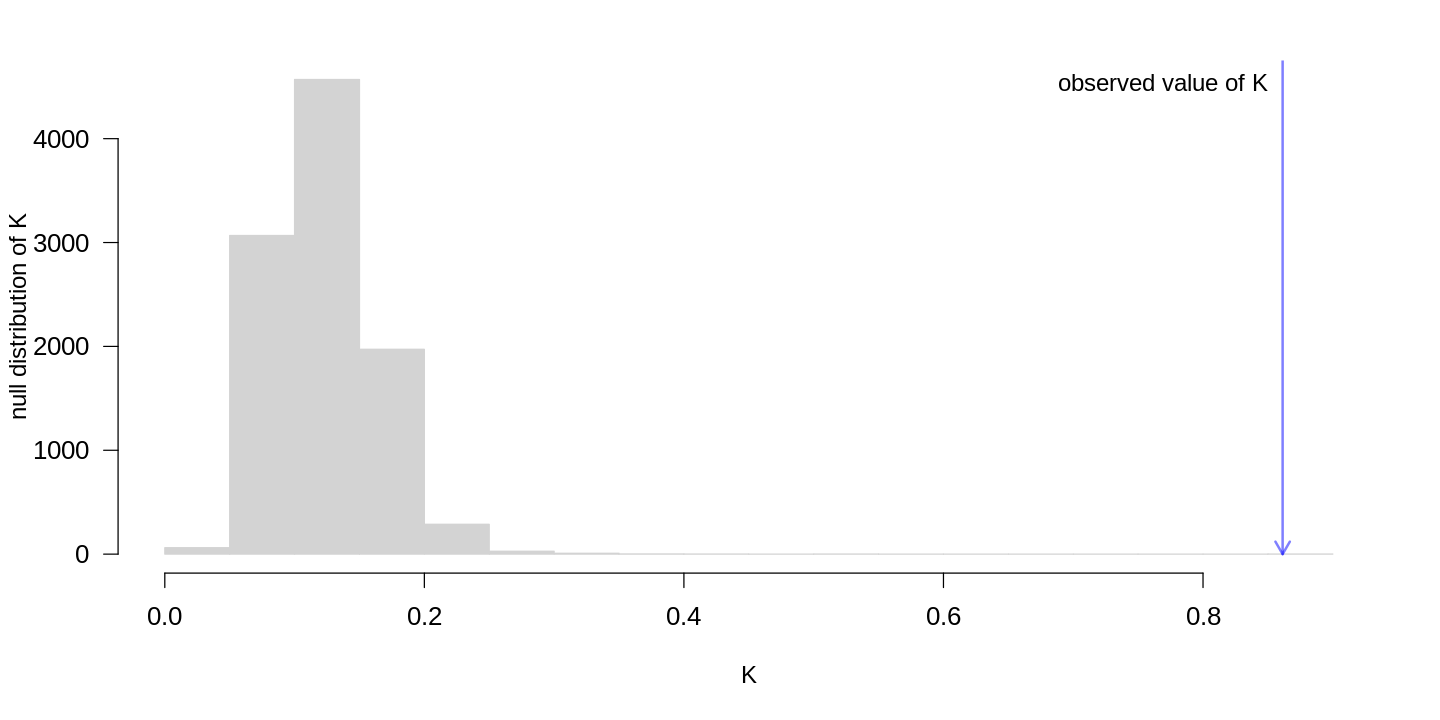

In [180]:
## test for significant phylogenetic signal using Blomberg’s K
K_test<-phylosig(primate_tree, orbit_area, test=TRUE, nsim=10000)
K_test

par(cex=1.2,mar=c(5.1,4.1,2.1,2.1))
plot(K_test,las=1,cex.axis=0.9)


Phylogenetic signal lambda : 1.00901 
logL(lambda) : -547.819 
LR(lambda=0) : 111.485 
P-value (based on LR test) : 4.63375e-26 


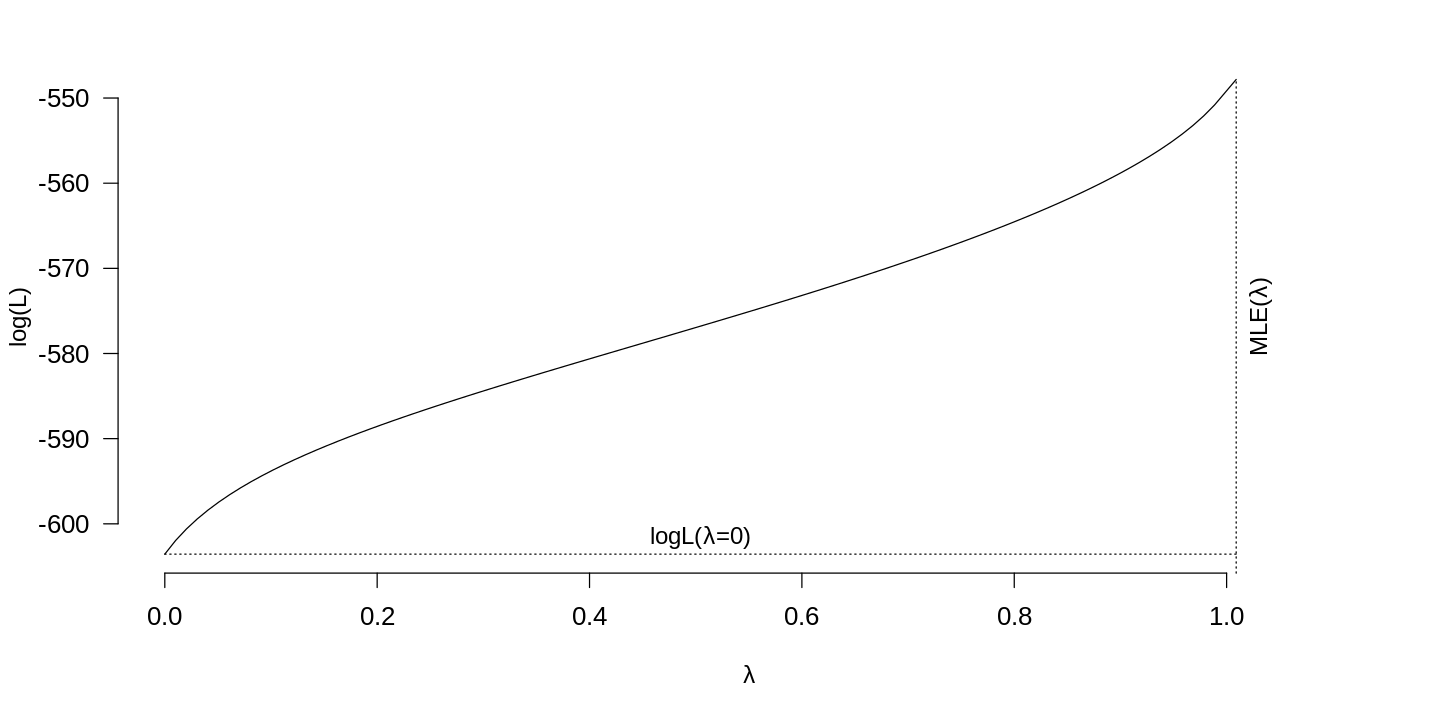

In [181]:
lambda_test <- phylosig(primate_tree,orbit_area,method="lambda",test=TRUE)
lambda_test

par(cex=1.2,mar=c(5.1,4.1,2.1,2.1))
plot(lambda_test,las=1,cex.axis=0.9,bty="n", xlim=c(0,1.1))

#### What we can conclude until now?

Given that the phylogenetic signal for orbit area is high and significant, it is essential to calculate the association between activity pattern and orbit area while controlling for phylogeny.
For this, we will introduce the Phylogenetic generalized least squares (PGLS), a very common method of phylogenetic analysis.

### Phylogenetic generalized least squares (PGLS)

The method of generalized least squares (GLS), first described by Aitken (1936), allows to account for the non independence of the residual error in a regression. PGLS models are an extension of this model for phylogenetic analysis.


In [192]:
#This function matches rows in a data frame to tips on a phylogeny and ensures correct ordering of the data with respect to the tips
comp.dat = comparative.data(primate_tree, data, names.col="Genus_species")

pgls_model = pgls(Orbit_area ~ Activity_pattern_code + Skull_length, data=comp.dat, lambda="ML")
summary(pgls_model)


Call:
pgls(formula = Orbit_area ~ Activity_pattern_code + Skull_length, 
    data = comp.dat, lambda = "ML")

Residuals:
    Min      1Q  Median      3Q     Max 
-42.110  -6.878  -1.672   6.084  50.965 

Branch length transformations:

kappa  [Fix]  : 1.000
lambda [ ML]  : 1.000
   lower bound : 0.000, p = 0.00019742
   upper bound : 1.000, p = 1    
   95.0% CI   : (0.749, NA)
delta  [Fix]  : 1.000

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -117.07443   52.51626 -2.2293  0.02837 *  
Activity_pattern_code   35.63624   14.69841  2.4245  0.01740 *  
Skull_length             5.08396    0.26484 19.1961  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 12.15 on 87 degrees of freedom
Multiple R-squared: 0.8095,	Adjusted R-squared: 0.8051 
F-statistic: 184.8 on 2 and 87 DF,  p-value: < 2.2e-16 

#### What you learned with this analysis?


We see that the activity pattern is still signicant, but now with p<0.05.
The overall analysis don't rule out the relationship between activity pattern and the orbit area. However, we learned that the phylogenetic signal for this trait in primates is very high, making the association between orbit area and activity pattern weaker then previous thought.


### Other models for continuous character evolution

#### Early burst (EB) model

#### The Ornstein–Uhlenbeck (OU) model

In [ ]:
#@title Fiting different models for trait evolution

# The main models behind phylogenetic corrections - discrete traits

### Markov chains

## Modeling discrete character evolution on a phylogeny
